In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys; sys.path.insert(0,'../codes/')
import prob_g3groupfinder as pg3
from group_purity import get_metrics_by_group, get_metrics_by_halo
from scipy.stats import binned_statistic, percentileofscore as pos
from copy import deepcopy
import pickle
import os

from matplotlib.ticker import MaxNLocator
from matplotlib import rcParams
from matplotlib.colors import LogNorm
rcParams['axes.labelsize'] = 9
rcParams['xtick.labelsize'] = 9
rcParams['ytick.labelsize'] = 9
rcParams['legend.fontsize'] = 9
rcParams['font.family'] = 'sans-serif'
#rcParams['font.sans-serif'] = ['Helvetica']
#rcParams['text.usetex'] = True
rcParams['grid.color'] = 'k'
rcParams['grid.linewidth'] = 0.2
my_locator = MaxNLocator(6)
singlecolsize = (3.3522420091324205, 2.0717995001590714)
doublecolsize = (7.100005949910059, 4.3880449973709)

In [3]:
# subvolumes = ['subvolume_0.0_to_0.2.pkl', 'subvolume_0.2_to_0.4.pkl', 'subvolume_0.4_to_0.6.pkl', 'subvolume_0.6_to_0.8.pkl', 'subvolume_0.8_to_1.0.pkl']

In [4]:
# vols = pickle.load(open('../data/subvolumes/volumes_h0.7.pkl','rb'))
# vols

In [5]:
# absmaglim = pickle.load(open('../data/subvolumes/completeness_h0.7.pkl','rb'))
# absmaglim

In [6]:
%matplotlib inline

In [14]:
subvolumes = ['../make_laduma_group_catalogs/subvolume_0.0_to_0.2_pg3.csv',\
              '../make_laduma_group_catalogs/subvolume_0.2_to_0.4_pg3.csv',\
              '../make_laduma_group_catalogs/subvolume_0.4_to_0.6_pg3.csv',\
              '../make_laduma_group_catalogs/subvolume_0.6_to_0.8_pg3.csv',\
              '../make_laduma_group_catalogs/subvolume_0.8_to_1.0_pg3.csv'\
             ]
meta = pd.read_csv('../data/subvolumes/subvolume_metadata.csv',sep='\t').set_index('File')
print(meta)

                              N  zmin  zmax    SA_str    VolMpc3  Mrlim
File                                                                   
subvolume_0.0_to_0.2.csv  28423   0.0   0.2  0.001115   202492.4 -15.56
subvolume_0.2_to_0.4.csv  23735   0.2   0.4  0.001089  1158223.0 -17.29
subvolume_0.4_to_0.6.csv  38100   0.4   0.6  0.001137  2656024.0 -18.34
subvolume_0.6_to_0.8.csv  33692   0.6   0.8  0.001117  4066637.0 -19.10
subvolume_0.8_to_1.0.csv  32037   0.8   1.0  0.001132  5431927.0 -19.70
subvolume_0.1_to_0.3.csv  26842   0.1   0.3  0.001102   599142.8 -16.56
subvolume_0.3_to_0.5.csv  24561   0.3   0.5  0.001104  1851917.0 -17.86
subvolume_0.5_to_0.7.csv  46204   0.5   0.7  0.001147  3438538.0 -18.75
subvolume_0.7_to_0.9.csv  32206   0.7   0.9  0.001127  4782995.0 -19.42
subvolume_0.9_to_1.1.csv  28107   0.9   1.1  0.001115  5910669.0 -19.96


4402


/tmp/ipykernel_2195692/312636649.py:15: DtypeWarning: Columns (86,118,185,189,197) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(subvolumes[ii])


16794


/tmp/ipykernel_2195692/312636649.py:15: DtypeWarning: Columns (86,103,118,185,189,197) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(subvolumes[ii])


27524


/tmp/ipykernel_2195692/312636649.py:15: DtypeWarning: Columns (86,103,118,185,189,197) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(subvolumes[ii])


25259


/tmp/ipykernel_2195692/312636649.py:15: DtypeWarning: Columns (86,103,118,127,131,185,189,197) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(subvolumes[ii])


24367


/tmp/ipykernel_2195692/312636649.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


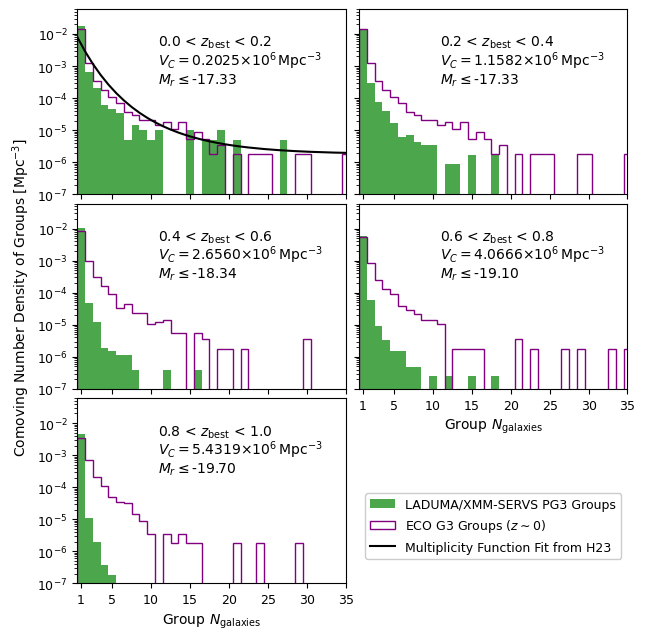

In [28]:
mos="""
ab
cd
e.
"""
ecovol = 192351./(0.7**3)
h23mult = lambda nn: 10**(3.9*np.exp(-0.13*nn))/ecovol

bv = np.arange(0.5,200.5,1)
tks = np.hstack([np.array([1]), np.arange(5,40,5)])
fig,axs=plt.subplot_mosaic(mos,figsize=(doublecolsize[0],doublecolsize[1]*1.7),sharey=True,gridspec_kw={'hspace':0.05,'wspace':0.05})
for ii,kk in enumerate(axs.keys()):
    if subvolumes[ii] is not None:
        #df = pickle.load(open(subvolumes[ii],'rb'))
        df = pd.read_csv(subvolumes[ii])
        print(len(df))
        idx = subvolumes[ii].split('/')[2].replace('_pg3','')
        subvol_lumlimit = meta.loc[idx,'Mrlim']
        ll = (-17.33 if subvol_lumlimit>-17.33 else subvol_lumlimit)
        vol = meta.loc[idx,'VolMpc3']
        df = df[df.absmag_R_VOICE<=ll]
        zmin, zmax = df.bestoverallz.min(), df.bestoverallz.max()
        #print(df.absrmag.max())
        grpn = pg3.multiplicity_function(df.pg3grp.to_numpy(),return_by_galaxy=False)
        #grpn = df.groupby('pg3id').first().pg3n.to_numpy()
        axs[kk].hist(grpn, bins=bv, color='green', alpha=0.7, weights=np.zeros_like(grpn)+1/vol, label='LADUMA/XMM-SERVS PG3 Groups', rasterized=True)
        
        
        eco = pd.read_csv("/srv/one/zhutchen/g3groupfinder/resolve_and_eco/ECOdata_G3catalog_luminosity.csv")
        eco = eco[(eco.absrmag<=ll)]
        g3grpn = pg3.multiplicity_function(eco.g3grp_l.to_numpy(),return_by_galaxy=False)
        axs[kk].hist(g3grpn, bins=bv, color='purple', histtype='step', weights=np.zeros_like(g3grpn)+1/ecovol, label=r'ECO G3 Groups ($z\sim 0$)', rasterized=True)
        if kk=='a': axs[kk].plot(bv, h23mult(bv), color='k', label=r'Multiplicity Function Fit from H23')

    
    axs[kk].annotate(xy=(0.3,0.8),xycoords='axes fraction',text='{a:0.1f} < '.format(a=zmin)+r'$z_{\rm best}$'+' < {b:0.1f}'.format(b=zmax))
    axs[kk].annotate(xy=(0.3,0.7),xycoords='axes fraction',text=r'$V_C=$'+'{a:0.4f}'.format(a=vol/1e6)+r'$\times 10^6\, {\rm Mpc^{-3}}$')
    axs[kk].annotate(xy=(0.3,0.6),xycoords='axes fraction',text=r'$M_r \leq$'+f"{ll:0.2f}")
    axs[kk].set_yscale('log')
    axs[kk].set_ylim(1e-7,6e-2)
    axs[kk].set_xlim(0.5,30.5)
    axs[kk].set_xticks(tks, labels=[])

axs['e'].set_xticks(tks, labels=tks)
axs['d'].set_xticks(tks, labels=tks)
axs['c'].set_ylabel(r"Comoving Number Density of Groups [$\rm Mpc^{-3}$]")    
axs['d'].set_xlabel(r"Group $N_{\rm galaxies}$")
axs['e'].set_xlabel(r"Group $N_{\rm galaxies}$")
axs['a'].legend(loc='lower left', framealpha=1, bbox_to_anchor=(1.05,-2))


plt.tight_layout()
plt.savefig("../figures/mult.png",dpi=300)
plt.show()

In [27]:
df = pd.read_csv('../data/subvolumes/subvolume_0.0_to_0.2.csv')

/tmp/ipykernel_2195692/2896964650.py:1: DtypeWarning: Columns (86,118) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/subvolumes/subvolume_0.0_to_0.2.csv')
